Neste exemplo, trabalharemos com os dados do naufrágio do Titanic.
Nosso objetivo é investigar quais variáveis impactaram na condição de sobrevivência (váriavel alvo).  

In [ ]:
# pacotes a instalar
#!pip install skimpy

# pacotes basicos para analise exploratoria de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import skew, kurtosis, kruskal
#from skimpy import skim


# estilo dos gráficos do Seaborn
sns.set_style("whitegrid")

In [ ]:
# carregando dados do titanic

df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

A partir de agora o nosso data frame que contem os dados do acidente do Titanic sera chamado de df.

pclass - Classe do passageiro

survived - sobreviveu (0 = não, 1 = sim)

name - Nome do passageiro

sex - Sexo do passageiro

age - Idade do passageiro

sibsp - Número de irmãos/esposa/marido embarcados

parch - Número de pais/filhos embarcados

ticket - Número d o bilhete de passagem

fare - Preço da passagem

cabin - cabine

embarked - Local de embarque

In [ ]:
#observar as primeiras linhas do banco de dados
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [ ]:
#informações basicas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Analise Univariada

Neste momento desejamos conhecer as características individuais de cada variável. Para isso vamos usar de estatísticas básicas, tabelas e elementos gráficos.

In [ ]:
# vamos criar um função para obter informações sobre valores ausentes, zeros e valores unicos.
def generate_summary(df):

  summary_data = []
  for column in df.columns:
    na_count = df[column].isnull().sum()
    zero_count = (df[column] == 0).sum()

    summary_data.append([
        column,
        df[column].nunique(),
        na_count,
        na_count / len(df) * 100,
        zero_count,
        zero_count / len(df) * 100,
        df[column].dtype
    ])

  summary_df = pd.DataFrame(summary_data, columns=[
      'variavel',
      'Únicos',
      'NA',
      '% de NA',
      'Zeros',
      '% de Zeros',
      'Tipo'
  ])

  return summary_df

# usando a função criada
generate_summary(df)

variavel  Únicos   NA    % de NA  Zeros  % de Zeros     Tipo
0   PassengerId     891    0   0.000000      0    0.000000    int64
1      Survived       2    0   0.000000    549   61.616162    int64
2        Pclass       3    0   0.000000      0    0.000000    int64
3          Name     891    0   0.000000      0    0.000000   object
4           Sex       2    0   0.000000      0    0.000000   object
5           Age      88  177  19.865320      0    0.000000  float64
6         SibSp       7    0   0.000000    608   68.237935    int64
7         Parch       7    0   0.000000    678   76.094276    int64
8        Ticket     681    0   0.000000      0    0.000000   object
9          Fare     248    0   0.000000     15    1.683502  float64
10        Cabin     147  687  77.104377      0    0.000000   object
11     Embarked       3    2   0.224467      0    0.000000   object

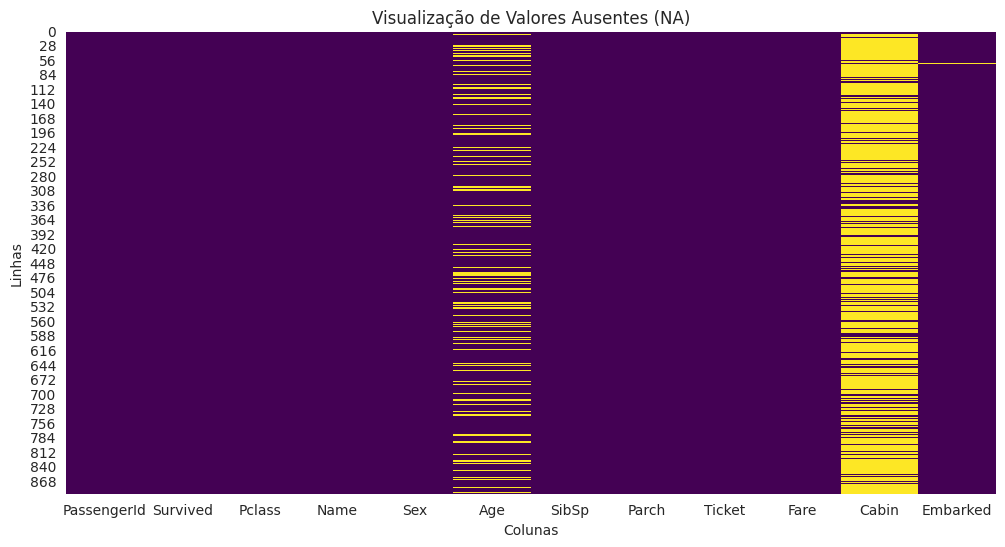

In [ ]:
#Visualisação grafica dos ausentes
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Visualização de Valores Ausentes (NA)')
plt.xlabel('Colunas')
plt.ylabel('Linhas')
plt.show()

In [ ]:
# remover variaveis que não utilizaremos na nossa analise.
df = df.drop(['PassengerId', 'Embarked', 'Ticket', 'Cabin'], axis=1)

# transformar em categorias algumas variaveis
df['Pclass'] = df['Pclass'].astype('category')
df['Sex'] = df['Sex'].astype('category')
df['Survived'] = df['Survived'].astype('category')

#>>>>>>>>> poderiamos automatizar
for column in df.columns:
  if pd.api.types.is_numeric_dtype(df[column]) and df[column].nunique() < 8:
    df[column] = df[column].astype('category')

#  if not pd.api.types.is_numeric_dtype(df[column]):
#    df[column] = df[column].astype('category')

df.dtypes

Survived    category
Pclass      category
Name          object
Sex         category
Age          float64
SibSp       category
Parch       category
Fare         float64
dtype: object

Funções de resumo, como o `describe` para variáveis numéricas, são uteis para termos um panorama geral dos valores numéricos.

In [ ]:
df.describe()

Age        Fare
count  714.000000  891.000000
mean    29.699118   32.204208
std     14.526497   49.693429
min      0.420000    0.000000
25%     20.125000    7.910400
50%     28.000000   14.454200
75%     38.000000   31.000000
max     80.000000  512.329200

In [ ]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types               Categories                                        │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                                │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                                │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                                │
│ │ Number of rows    │ 891    │ │ category    │ 5     │ │ Survived              │                                │
│ │ Number of columns │ 8      │ │ float64     │ 2     │ │ Pclass                │                                │
│ └───────────────────┴────────┘ │ string      │ 1     │ │ Sex                   │                                │
│                                └─────────────┴───────┘ │ SibSp                 │                                │
│                                                        │ Parch                 │                                │
│                                                        └───────────────────────┘                                │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name     ┃ NA    ┃ NA %    ┃ mean   ┃ sd      ┃ p0     ┃ p25     ┃ p50     ┃ p75  ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ Age             │   177 │   19.87 │   29.7 │   14.53 │   0.42 │   20.12 │      28 │   38 │     80 │ ▂▇▇▃▁  │  │
│ │ Fare            │     0 │       0 │   32.2 │   49.69 │      0 │    7.91 │   14.45 │   31 │  512.3 │   ▇    │  │
│ └─────────────────┴───────┴─────────┴────────┴─────────┴────────┴─────────┴─────────┴──────┴────────┴────────┘  │
│                                                    category                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                      ┃ NA        ┃ NA %           ┃ ordered               ┃ unique             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Survived                         │         0 │              0 │ False                 │                  2 │  │
│ │ Pclass                           │         0 │              0 │ False                 │                  3 │  │
│ │ Sex                              │         0 │              0 │ False                 │                  2 │  │
│ │ SibSp                            │         0 │              0 │ False                 │                  7 │  │
│ │ Parch                            │         0 │              0 │ False                 │                  7 │  │
│ └──────────────────────────────────┴───────────┴────────────────┴───────────────────────┴────────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Name                      │       0 │          0 │                          4.1 │                     3626 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── 

In [ ]:
# transformar Pclass para ordenado
df['Pclass'] = pd.Categorical(df['Pclass'], categories=[1, 2, 3], ordered=True)

# verificar as categorias
df['Pclass'].cat.categories

Index([1, 2, 3], dtype='int64')

### Valores numéricos

In [ ]:
# vamos dar uma incrementada na função 'describe'
def full_summary(df):
    # usa describe para gerar estatísticas básicas

    summary = df.describe().T # transposta

    # seleciona apenas as colunas numéricas para os cálculos

    numeric_cols = df.select_dtypes(include=['number']).columns


    summary['IQR'] =  df[numeric_cols].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))

    # adiciona skewness (assimetria)
    summary['skewness'] = df[numeric_cols].apply(lambda x: skew(x.dropna()))

    # adiciona  kurtosis (curtose)
    summary['kurtosis'] = df[numeric_cols].apply(lambda x: kurtosis(x.dropna()))

    return summary

#  resumo
full_summary(df)

count       mean        std   min      25%      50%   75%       max  \
Age   714.0  29.699118  14.526497  0.42  20.1250  28.0000  38.0   80.0000   
Fare  891.0  32.204208  49.693429  0.00   7.9104  14.4542  31.0  512.3292   

          IQR  skewness   kurtosis  
Age   17.8750  0.388290   0.168637  
Fare  23.0896  4.779253  33.204289

Skewness indica assimetria, quanto mais proximo a zero, mais simetrico.

Kurtosis é um bom indicador de existencia de outliers, valores superiores a 3 devem ser observados com atenção.

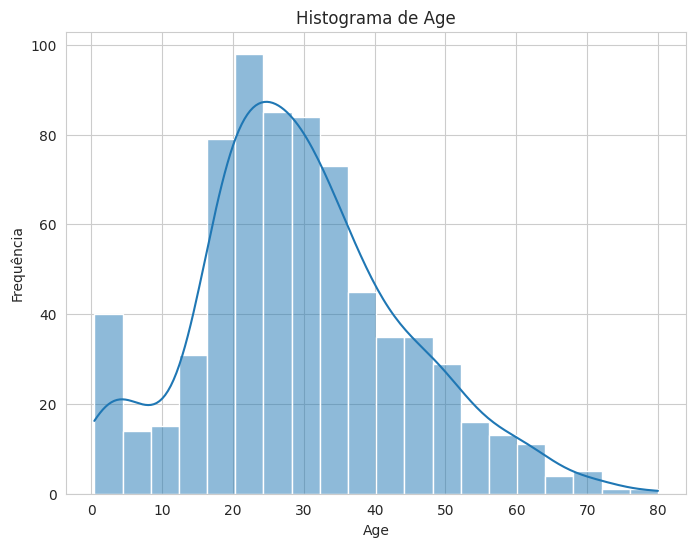

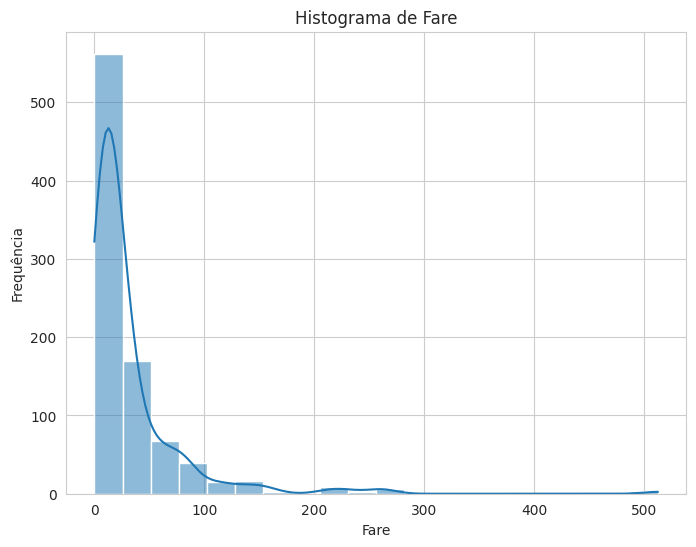

In [ ]:
# Gerar histogramas para as variáveis numéricas
for column in df.columns:
  if pd.api.types.is_numeric_dtype(df[column]):
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column], kde=True,bins=20)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')
    plt.show()

Um ponto importante, é analisarmos a distribuição dos dados quanto a sua normalidade. Podemos usar elementos gráficos como o QQ-plot.

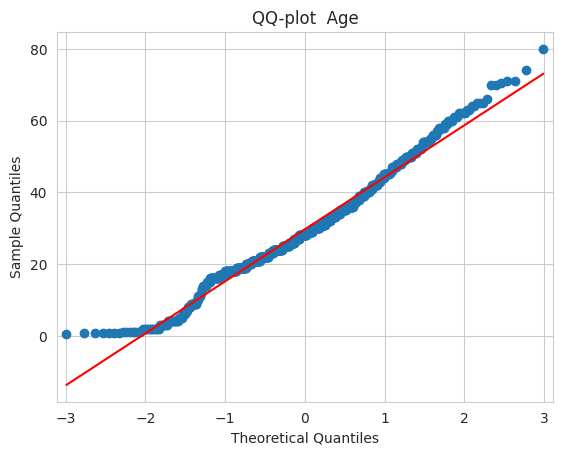

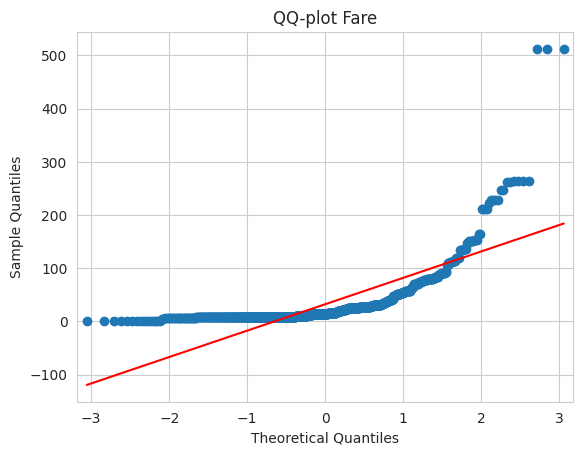

In [ ]:
# QQ-plot
sm.qqplot(df['Age'].dropna(), line='s')
plt.title('QQ-plot  Age')
plt.show()

# QQ-plot
sm.qqplot(df['Fare'].dropna(), line='s')
plt.title('QQ-plot Fare')
plt.show()

Podemos utilizar testes estatísticos de normalidade como Shapior-Wilk e Kolmogorov-Smirnov


In [ ]:
from scipy.stats import shapiro, kstest

# teste de Shapiro-Wilk para verificar a normalidade
print(shapiro(df['Age'].dropna())) # H0 é destribuição normal, para isso P>0.05

# teste de Kolmogorov-Smirnov para verificar a normalidade
kstest(df['Age'].dropna(), 'norm') # H0 é destribuição normal, para isso P>0.05

ShapiroResult(statistic=0.9814577414504954, pvalue=7.337348958673594e-08)


KstestResult(statistic=0.9650366565902186, pvalue=0.0, statistic_location=3.0, statistic_sign=-1)

O boxplot é outra maneira comumente utilizada para observação de variáveis numéricas.

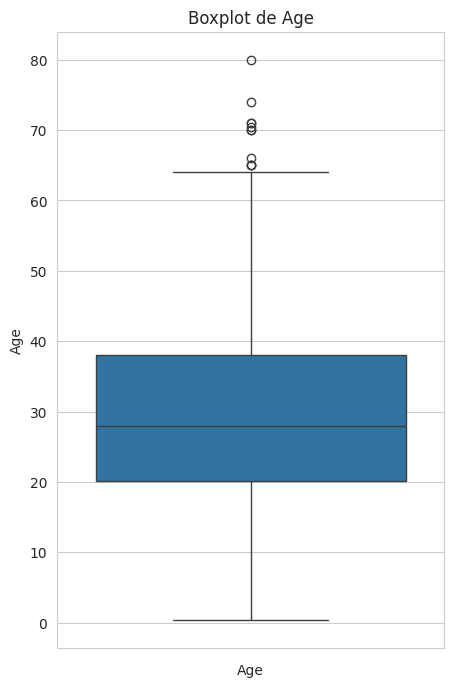

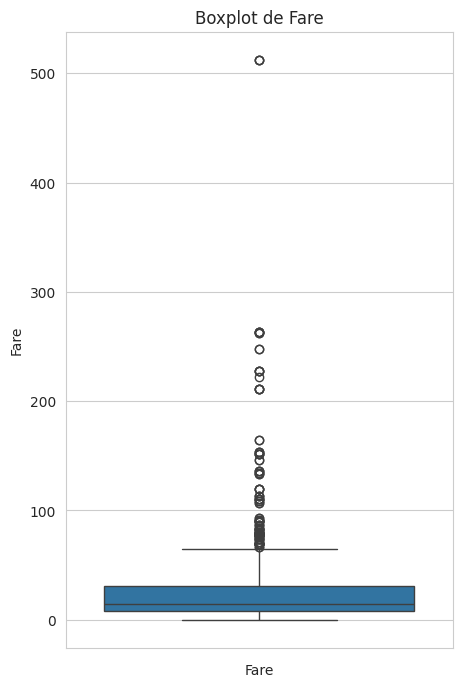

In [ ]:
# boxplots para as variáveis numéricas
for column in df.columns:
  if pd.api.types.is_numeric_dtype(df[column]):
    plt.figure(figsize=(5, 8))
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot de {column}')
    plt.xlabel(column)
    plt.show()


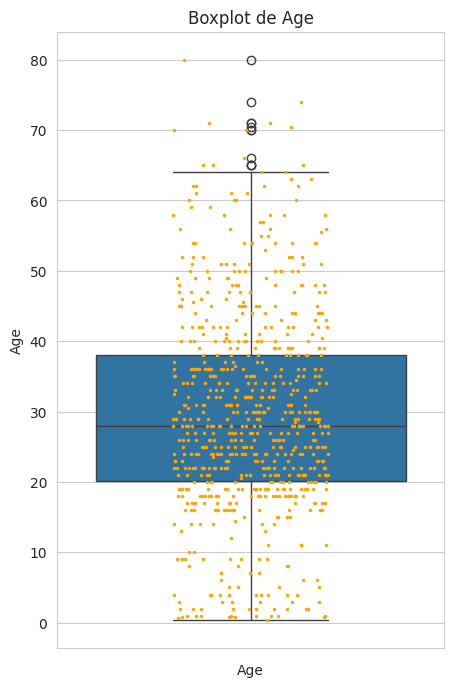

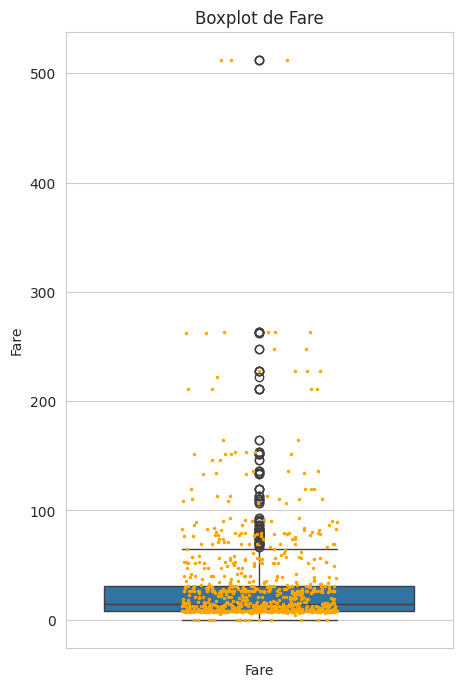

In [ ]:
# boxplots para as variáveis numéricas
for column in df.columns:
  if pd.api.types.is_numeric_dtype(df[column]):
    plt.figure(figsize=(5, 8))
    sns.boxplot(y=df[column])
    sns.stripplot(y=df[column], color='orange',jitter=0.2, size=2.5)
    plt.title(f'Boxplot de {column}')
    plt.xlabel(column)
    plt.show()

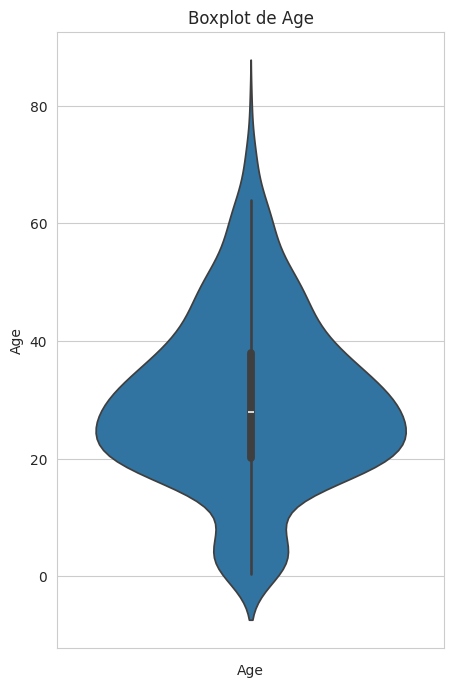

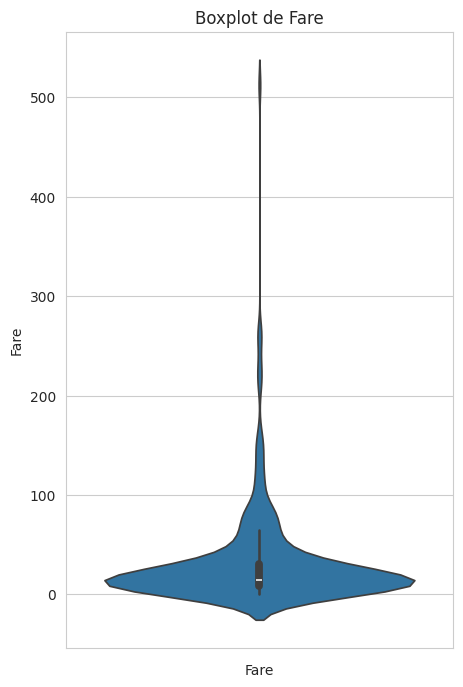

In [ ]:
# violino
for column in df.columns:
  if pd.api.types.is_numeric_dtype(df[column]):
    plt.figure(figsize=(5, 8))
    sns.violinplot(y=df[column])
    plt.title(f'Boxplot de {column}')
    plt.xlabel(column)
    plt.show()

# Variaveis Categoricas

Iniciamos observando em foram de tabela de frequencias, podendo ser relativas e absolutas

In [ ]:
# Percentual de cada categoria

df['Sex'].value_counts(normalize=True) * 100

Sex
male      64.758698
female    35.241302
Name: proportion, dtype: float64

In [ ]:
df['Survived'].value_counts(normalize=True) * 100

Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64

In [ ]:
df['Pclass'].value_counts(normalize=True) * 100

Pclass
3    55.106622
1    24.242424
2    20.650954
Name: proportion, dtype: float64

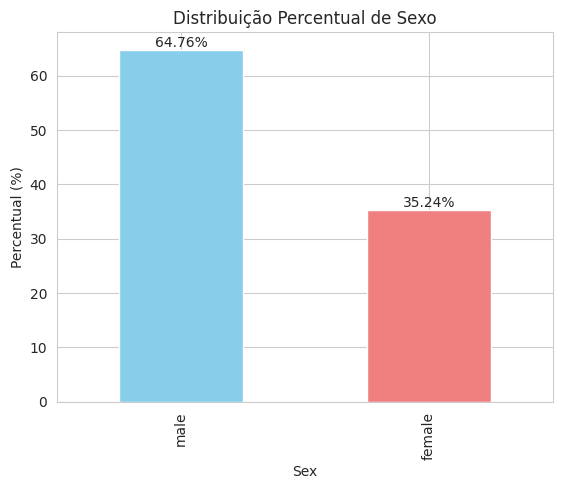

Sex
male      64.758698
female    35.241302
Name: proportion, dtype: float64

In [ ]:
sex_dist=df['Sex'].value_counts(normalize=True) * 100

# gráfico de barras
sex_dist.plot(kind='bar', color=['skyblue', 'lightcoral'])

# posisionar o valor de %
for i, valor in enumerate(sex_dist):
    plt.text(i, valor, f'{valor:.2f}%', ha='center', va='bottom')

plt.ylabel('Percentual (%)')
plt.title('Distribuição Percentual de Sexo')

plt.show()
sex_dist # tabela

In [ ]:
# caso for de interesse saber numero absoluto
counts = df['Survived'].value_counts()
percentages = df['Survived'].value_counts(normalize=True) * 100

# Calcular as porcentagens
pd.DataFrame({'Counts': counts, 'Percentages': percentages})

Counts  Percentages
Survived                     
0            549    61.616162
1            342    38.383838

# Analise Multivariada

Agora vamos buscar a relação entre as variáveis. Em especial com a nossa variável alvo.

### Numerico x Categorico

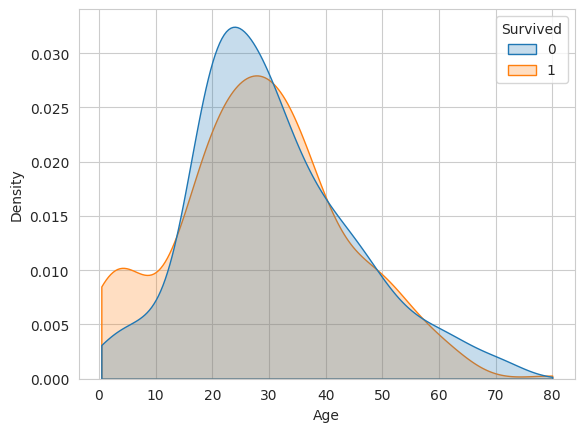

In [ ]:
# graficos de distribuição de densidade

sns.kdeplot(data=df,x="Age",hue='Survived',fill=True,common_norm=False, clip=(df['Age'].min(),df['Age'].max())  )

plt.show()

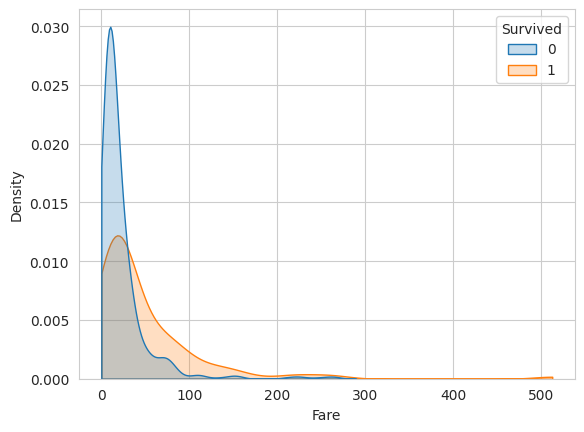

In [ ]:
sns.kdeplot(data=df,x="Fare",hue='Survived',fill=True,common_norm=False,clip=(df['Fare'].min(),df['Fare'].max() ))

plt.show()

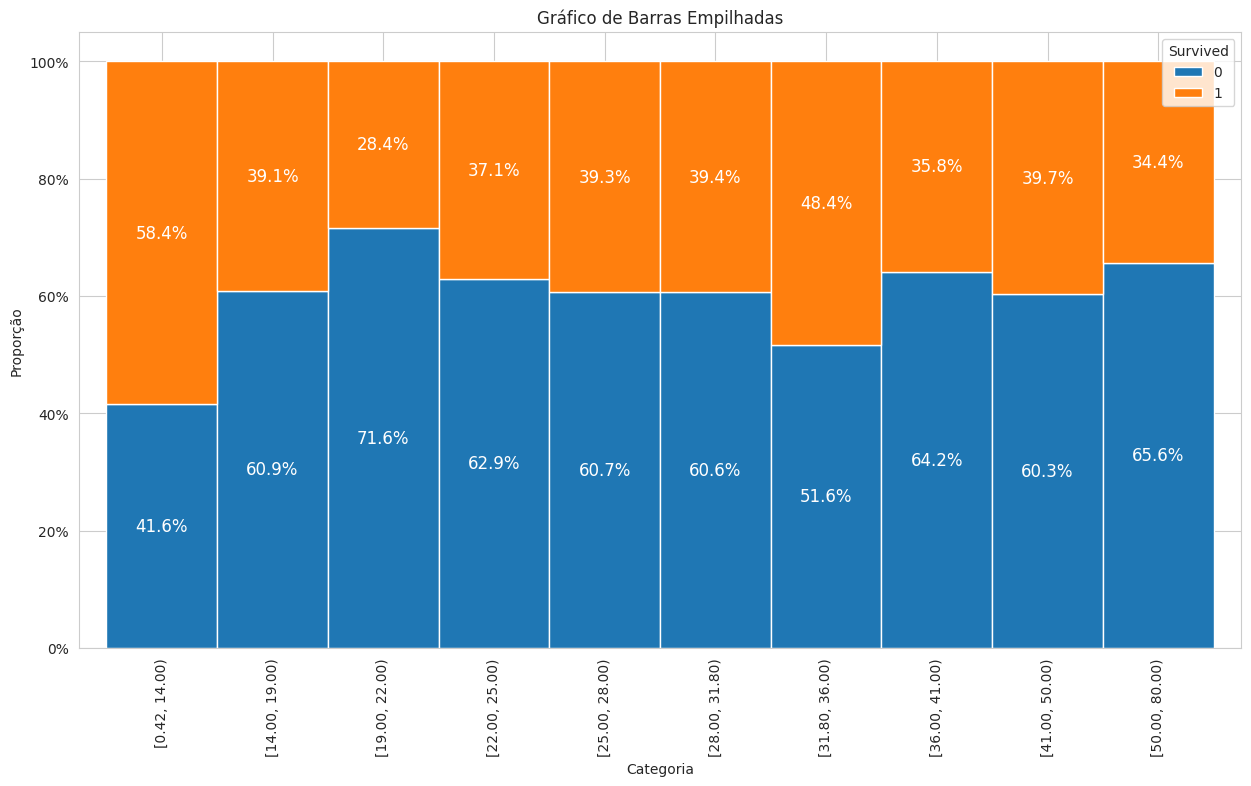

In [ ]:
from matplotlib.ticker import PercentFormatter

#passar valores numericos para intervalos (categoricos)
#df['fare_interval'] = pd.qcut(df['age'], q=10, labels=[f"Q{i+1}" for i in range(10)])
df['age_quantile'], bins = pd.qcut(df['Age'], q=10, labels=False, retbins=True)


# Criar uma tabela de contingência (cross-tab) para categorias
cross_tab = pd.crosstab(df['age_quantile'], df['Survived'],  normalize='index')



# Plotar as barras empilhadas
ax=cross_tab.plot(kind='bar', stacked=True,width=1,figsize=(15,8))

interval_labels = [f'[{bins[i]:.2f}, {bins[i+1]:.2f})' for i in range(len(bins)-1)]
ax.set_xticklabels(interval_labels)


# Adicionar rótulos e título
plt.title('Gráfico de Barras Empilhadas')
plt.ylabel('Proporção')
plt.xlabel('Categoria')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1)) #porcentagem

for p in ax.patches:
    width = p.get_width()    # Largura da barra
    height = p.get_height()  # Altura da barra (proporção)
    x, y = p.get_xy()        # Posição da barra
    if height > 0:           # Adicionar porcentagem se houver altura
        ax.text(x + width / 2, y + height / 2, f'{height:.1%}',
                ha='center', va='center', color='white', fontsize=12)

# Exibir o gráfico
plt.show()


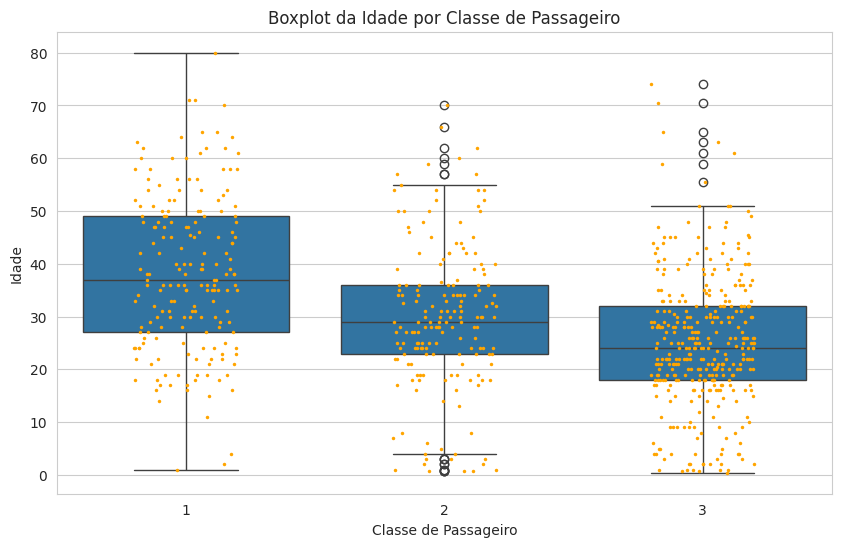

In [ ]:
# relacionar por meio de boxplot as idades pela classe

plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='Age', data=df)
plt.title('Boxplot da Idade por Classe de Passageiro')
plt.xlabel('Classe de Passageiro')
plt.ylabel('Idade')

# Adicionar os pontos individuais ao boxplot
#sns.stripplot(x='Pclass', y='Age', data=df, color='black', size=3, jitter=True)

plt.show()


In [ ]:
#Kruskal-Wallis (numerico x categorico, não parametrico), caso parametrico ANOVA: Testa se há diferenças significativas entre as distribuições
kruskal(df[df['Pclass'] == 1]['Age'].dropna(),
                               df[df['Pclass'] == 2]['Age'].dropna(),
                               df[df['Pclass'] == 3]['Age'].dropna())

KruskalResult(statistic=95.99479230295296, pvalue=1.4288798296552103e-21)

### Categorico x categorico

Tabela de contigencia e suas formas graficas de representa-la

Survived         0         1
Sex                         
female    0.257962  0.742038
male      0.811092  0.188908


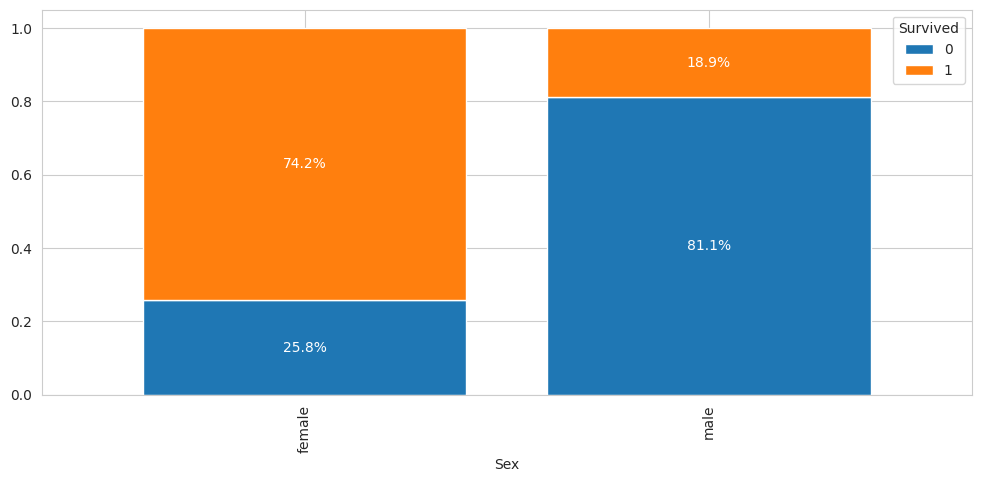

In [ ]:
cross_tab = pd.crosstab(df['Sex'], df['Survived'],  normalize='index')
print(cross_tab)
ax=cross_tab.plot(kind='bar', stacked=True,width=0.8,figsize=(12,5))
for p in ax.patches:
    width = p.get_width()    # Largura da barra
    height = p.get_height()  # Altura da barra (proporção)
    x, y = p.get_xy()        # Posição da barra
    if height > 0:           # Adicionar porcentagem se houver altura
        ax.text(x + width / 2, y + height / 2, f'{height:.1%}',
                ha='center', va='center', color='white', fontsize=10)
plt.show()

Pclass           1         2         3
Survived                              
0         0.145719  0.176685  0.677596
1         0.397661  0.254386  0.347953


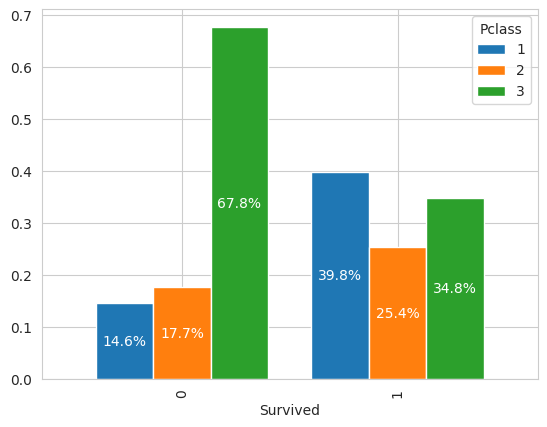

In [ ]:
cross_tab = pd.crosstab(df['Survived'], df['Pclass'],  normalize='index')
print(cross_tab)
ax=cross_tab.plot(kind='bar', stacked=False,width=0.8 )
for p in ax.patches:
    width = p.get_width()    # Largura da barra
    height = p.get_height()  # Altura da barra (proporção)
    x, y = p.get_xy()        # Posição da barra
    if height > 0:           # Adicionar porcentagem se houver altura
        ax.text(x + width / 2, y + height / 2, f'{height:.1%}',
                ha='center', va='center', color='white', fontsize=10)
plt.show()


plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


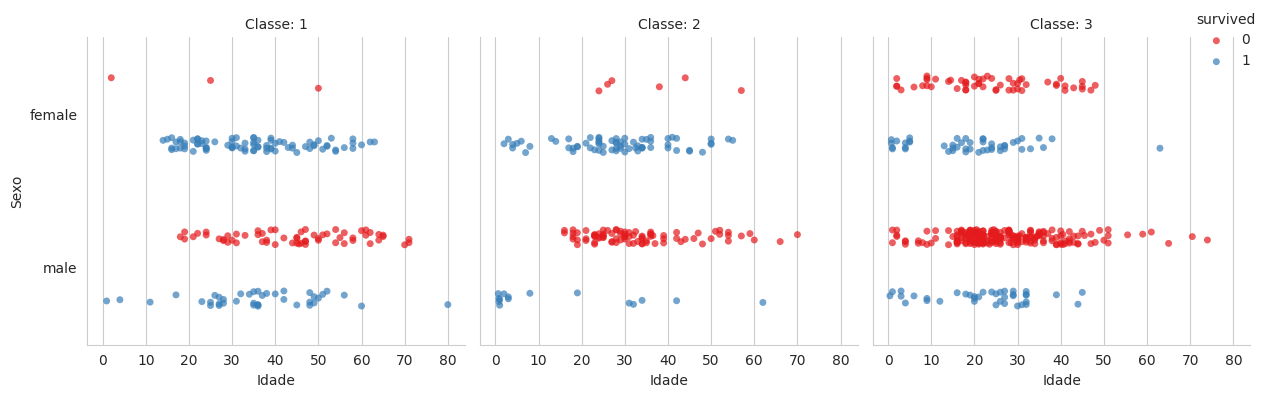

In [ ]:

# Criar o gráfico usando FacetGrid (separa as classes)
g = sns.FacetGrid(df, col='Pclass', height=4, aspect=1)

g.map(sns.stripplot, 'Age', 'Sex', hue='Survived', data=df, jitter=True, dodge=True, palette='Set1', alpha=0.7)

# Adicionar título e legendas
g.set_titles(col_template="Classe: {col_name}")
g.set_axis_labels("Idade", "Sexo")
g.add_legend(title='survived', loc='upper right', labels=['0', '1'])

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()

### Manipulação de variaveis

Vamos tentar extrarir informação do Nome dos passageiros

In [ ]:
# selecionar qualquer sequencia de caracter depois antes do ponto.
df['Titulo'] = df['Name'].str.extract(r'([A-Za-z]+)\.')
df.head()

Survived Pclass                                               Name     Sex  \
0        0      3                            Braund, Mr. Owen Harris    male   
1        1      1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   
2        1      3                             Heikkinen, Miss. Laina  female   
3        1      1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
4        0      3                           Allen, Mr. William Henry    male   

    Age SibSp Parch     Fare Titulo  
0  22.0     1     0   7.2500     Mr  
1  38.0     1     0  71.2833    Mrs  
2  26.0     0     0   7.9250   Miss  
3  35.0     1     0  53.1000    Mrs  
4  35.0     0     0   8.0500     Mr

In [ ]:
# vamos visualisar quanto nomes temos
counts = df['Titulo'].value_counts()
percentages = df['Titulo'].value_counts(normalize=True) * 100

# Calcular as porcentagens
counts=pd.DataFrame({'Counts': counts, 'Percentages': percentages})
counts

Counts  Percentages
Titulo                       
Mr           517    58.024691
Miss         182    20.426487
Mrs          125    14.029181
Master        40     4.489338
Dr             7     0.785634
Rev            6     0.673401
Mlle           2     0.224467
Major          2     0.224467
Col            2     0.224467
Countess       1     0.112233
Capt           1     0.112233
Ms             1     0.112233
Sir            1     0.112233
Lady           1     0.112233
Mme            1     0.112233
Don            1     0.112233
Jonkheer       1     0.112233

In [ ]:
# vamos transformar os valores menores em "Outros"
df['Titulo'] = np.where(df['Titulo'].isin(counts[counts['Counts'] > 7].index), df['Titulo'], 'Outros')
df['Titulo'].value_counts()

Titulo
Mr        517
Miss      182
Mrs       125
Master     40
outros     27
Name: count, dtype: int64

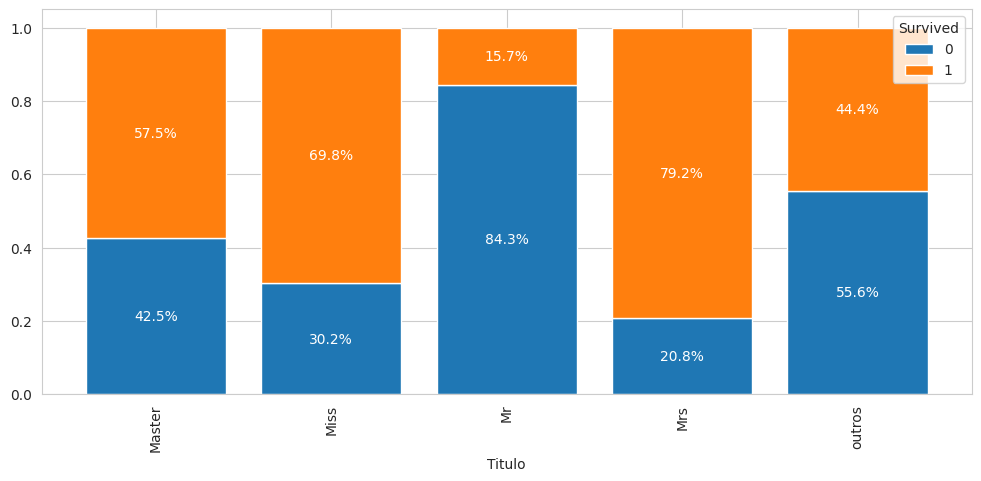

In [ ]:
cross_tab=pd.crosstab(df['Titulo'], df['Survived'],  normalize='index')
ax=cross_tab.plot(kind='bar', stacked=True,width=0.8,figsize=(12,5))
for p in ax.patches:
    width = p.get_width()    # Largura da barra
    height = p.get_height()  # Altura da barra (proporção)
    x, y = p.get_xy()        # Posição da barra
    if height > 0:           # Adicionar porcentagem se houver altura
        ax.text(x + width / 2, y + height / 2, f'{height:.1%}',
                ha='center', va='center', color='white', fontsize=10)
plt.show()

In [ ]:



# Somar 'SibSp' e 'Parch' +1 para obter o tamanho total da familia
df['SibSp'] = pd.to_numeric(df['SibSp'], errors='coerce')
df['Parch'] = pd.to_numeric(df['Parch'], errors='coerce')
df['Familia'] = df['SibSp'] + df['Parch'] +1

df.head()

Survived Pclass                                               Name     Sex  \
0        0      3                            Braund, Mr. Owen Harris    male   
1        1      1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   
2        1      3                             Heikkinen, Miss. Laina  female   
3        1      1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
4        0      3                           Allen, Mr. William Henry    male   

    Age  SibSp  Parch     Fare Titulo  age_quantile  Familia  
0  22.0      1      0   7.2500     Mr           2.0        2  
1  38.0      1      0  71.2833    Mrs           7.0        2  
2  26.0      0      0   7.9250   Miss           4.0        1  
3  35.0      1      0  53.1000    Mrs           6.0        2  
4  35.0      0      0   8.0500     Mr           6.0        1

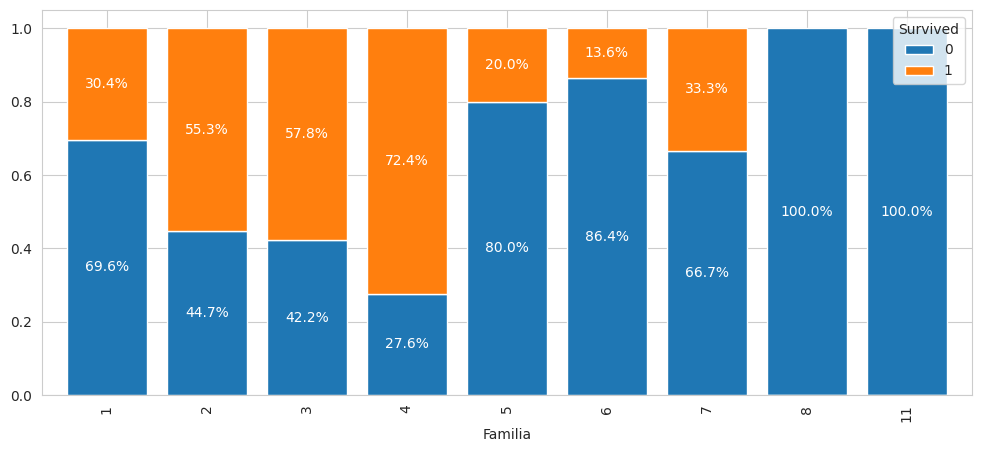

Familia
1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
dtype: int64

In [ ]:
cross_tab=pd.crosstab(df['Familia'], df['Survived'],  normalize='index')
ax=cross_tab.plot(kind='bar', stacked=True,width=0.8,figsize=(12,5))
for p in ax.patches:
    width = p.get_width()    # Largura da barra
    height = p.get_height()  # Altura da barra (proporção)
    x, y = p.get_xy()        # Posição da barra
    if height > 0:           # Adicionar porcentagem se houver altura
        ax.text(x + width / 2, y + height / 2, f'{height:.1%}',
                ha='center', va='center', color='white', fontsize=10)
plt.show()
pd.crosstab(df['Familia'], df['Survived']).sum(axis=1)

In [ ]:
# maioria homem solo?
len(df[(df['Sex'] == 'male') & (df['Familia'] == 1)])

411

<ipython-input-88-0e43848bdc4e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = le_sex.fit_transform(X['Sex'])


Precisão do modelo: 0.8212290502793296


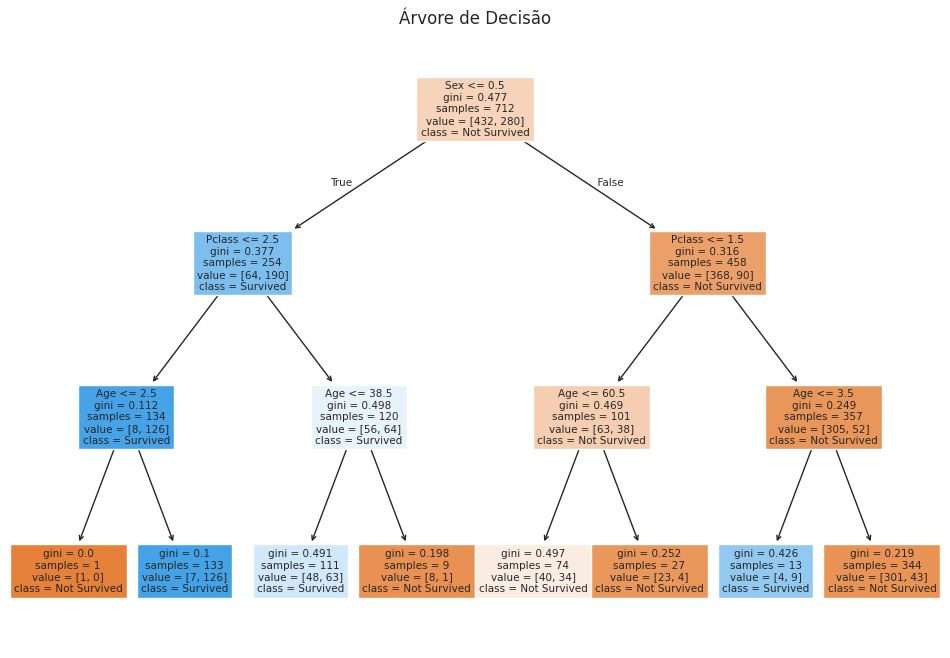

In [ ]:
from sklearn.tree import DecisionTreeClassifier,  plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder



X = df[['Pclass', 'Sex', 'Age']]  # Selecionar váriaveis (colunas) forçantes
y = df['Survived'] # Alvo (dependente)

# Codificar a variável categórica 'Sex'
le_sex = LabelEncoder()
X['Sex'] = le_sex.fit_transform(X['Sex'])


# Dividir os dados em conjuntos de treinamento e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Criar o modelo de árvore de decisão
model = DecisionTreeClassifier(max_depth=3, random_state=24)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisão do modelo:", accuracy)

# Visualizar a árvore de decisão
plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=X.columns, class_names=['Not Survived', 'Survived'], filled=True)
plt.title('Árvore de Decisão')
plt.show()

In [ ]:
#matrix de confusão
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm, index=['Prev. Not Survived', 'Prev. Survived'], columns=['Not Survived', 'Survived'])
cm_df

Not Survived  Survived
Prev. Not Survived           103        14
Prev. Survived                23        39

In [ ]:
# Gerar o relatório de métricas
relatorio = classification_report(y_test, y_pred)

# Exibir o relatório
print(relatorio)

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       117
           1       0.75      0.73      0.74        62

    accuracy                           0.82       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



In [ ]:
#!pip install sweetviz

import sweetviz as sv


report = sv.analyze(df, target_feat='Survived')

#report.show_notebook() # para mostrar direto no notebook
report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
#!pip install ydata-profiling
from ydata_profiling import ProfileReport


# gerar relatorio
report=ProfileReport(df)
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]